<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Импорт-и-первоначальное-рассмотрение-данных" data-toc-modified-id="Импорт-и-первоначальное-рассмотрение-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импорт и первоначальное рассмотрение данных</a></span></li><li><span><a href="#Преобразование-текстовых-данных" data-toc-modified-id="Преобразование-текстовых-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Преобразование текстовых данных</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LGBM" data-toc-modified-id="LGBM-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>LGBM</a></span></li><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#Dummy" data-toc-modified-id="Dummy-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Dummy</a></span></li><li><span><a href="#Сравнительная-таблица-моделей" data-toc-modified-id="Сравнительная-таблица-моделей-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Сравнительная таблица моделей</a></span></li></ul></li><li><span><a href="#Тест" data-toc-modified-id="Тест-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тест</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li>

# Классификация токсичных комментариев

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо обучить модель классифицировать комментарии на позитивные и негативные. В распоряжении набор данных с разметкой о токсичности правок.

## Подготовка

### Импорт и первоначальное рассмотрение данных

Изначально импортируем необходимые библиотеки.

In [1]:
import re
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier

from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

import nltk

from wordcloud import WordCloud

import spacy

Зададим датасет и выведем о нем информацию. Зададим параметр `index_col=0`, чтобы не было столбца `Unnamed: 0`.

In [2]:
data = pd.read_csv('datasets/toxic_comments.csv', index_col=0)

In [3]:
data.sample(10)

,text,toxic
61268,STOP \n\nQuit commenting on my talk page as a ...,1
83450,Multiculturalist sock puppet==\n\nSomeone just...,0
73545,"""\n Hello, XIHaRtAtTaCkIx and Welcome to Wikip...",0
66633,"Well, with all the cross-references the direct...",0
36908,Well your...\nWell your stupidiness will be th...,1
3402,Utterly stupid suggestion. I am sure Wikipedia...,1
105557,Category:Georgia (country) international footb...,0
74131,"I'm not 100% positive, but I think only Wikipe...",0
39601,Contact\nPlease email me privately. There's a ...,0
121495,"Autor \n\nHi, who was the autor of this pictur...",0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


Рассмотрим баланс классов.

In [5]:
labels = {0: 'not toxic', 1: 'toxic'}

vc = data['toxic'].value_counts().rename_axis('class').to_frame('count')
vc['share_%'] = (vc['count'] / vc['count'].sum() * 100).round(2)
vc.index = vc.index.map(labels)
vc


,count,share_%
class,,
not toxic,143106,89.84
toxic,16186,10.16


Классы несбалансированы. Данную проблему решим установлением соответствующих гиперпараметров в моделях и подобором порога.

### Преобразование текстовых данных

Создадим необходимые условия для машинного обучения текстовых данных.

Взглянем на корпус постов.

In [6]:
corpus = data['text'].values
corpus[:3]

array(["Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",
       "D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)",
       "Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info."],
      dtype=object)

Далее проведем леммантизацию и очистку текста от лишнего. Оформим необходимую функцию и применим ее к столбцу с постами.

In [7]:
#nlp = spacy.load("en_core_web_sm")

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

In [8]:
import re

def lemma_clear(doc):
    """Принимает spaCy Doc (НЕ строку). Возвращает очищенную лемматизированную строку."""
    tokens = []
    for t in doc:
        if t.is_space or t.is_punct or t.like_url or t.like_email:
            continue

        lemma = re.sub(r"[^a-z0-9\*\$@!]+", "", t.lemma_.lower())
        if lemma:
            tokens.append(lemma)

    return " ".join(tokens)


In [9]:
sentence1 = "The striped bats are hanging on their feet for best"
print(f'до лемматизации: \n {sentence1}')

до лемматизации: 
 The striped bats are hanging on their feet for best


In [10]:
doc1 = nlp(sentence1)        
print("после:")
print(lemma_clear(doc1))

после:
the striped bat be hang on their foot for good


In [11]:
from tqdm import tqdm
tqdm.pandas()

In [12]:
%%time

texts = data["text"].astype(str)
docs = nlp.pipe(texts, batch_size=1000)
data["lemm_text"] = [lemma_clear(doc) for doc in tqdm(docs, total=len(texts))]


100%|██████████████████████████████████████████████████████████████████████████| 159292/159292 [33:21<00:00, 79.60it/s]

CPU times: total: 32min 46s
Wall time: 33min 21s


Посмотрим, что получилось.

In [13]:
data.sample(10)

,text,toxic,lemm_text
121657,"and you are a mormon as well, so this mormonic...",0,and you be a mormon as well so this mormonic v...
118366,DRM Controversy\nThere is a problem with the D...,0,drm controversy there be a problem with the dr...
91695,Bombs awwwaaaayyyyy \n\nWikipedia:Featured_art...,0,bomb awwwaaaayyyyy wikipedia featuredarticleca...
67071,Like having sex with inflatable animals?,1,like have sex with inflatable animal
131498,hey \n\nI just added the archive header to the...,0,hey i just add the archive header to the archi...
68392,to withdraw $10USD from your bank account,0,to withdraw $ 10usd from your bank account
112562,This is not an article about scholarship on th...,0,this be not an article about scholarship on th...
17201,", 25 November 2007 (UTC)\n\nBut the ride video...",0,25 november 2007 utc but the ride video be sti...
108160,WrestleMania \n\nYou son of a bitch!!! a Moron!,1,wrestlemania you son of a bitch a moron
159377,"I am not a martyr. I am a human, and humans ma...",0,i be not a martyr i be a human and human make ...


Выведем облако слов для и токсичных нетоксичных текстов.

In [14]:
not_toxic_data = data[data['toxic'] == 0]
not_toxic_data['lemm_text']

0         explanation why the edit make under my usernam...
1         daww he match this background colour i be seem...
2         hey man i be really not try to edit war it be ...
3         more i can not make any real suggestion on imp...
4         you sir be my hero any chance you remember wha...
                                ...                        
159446    and for the second time of ask when your view ...
159447    you should be ashamed of yourself that be a ho...
159448    spitzer umm there s no actual article for pros...
159449    and it look like it be actually you who put on...
159450    and i really do not think you understand i com...
Name: lemm_text, Length: 143106, dtype: object

In [15]:
toxic_data = data[data['toxic'] == 1]
toxic_data['lemm_text']

6               cocksucker before you pis around on my work
12        hey what be it talk what be it an exclusive gr...
16        bye do not look come or think of comme back to...
42        you be gay or antisemmitian archangel white ti...
43                   fuck your filthy mother in the ass dry
                                ...                        
159374    our previous conversation you fuck shit eat li...
159394                     you be a mischievious pubic hair
159421    your absurd edit your absurd edit on great whi...
159426    hey listen do not you ever delete my edit ever...
159434    and i be go to keep post the stuff u delete un...
Name: lemm_text, Length: 16186, dtype: object

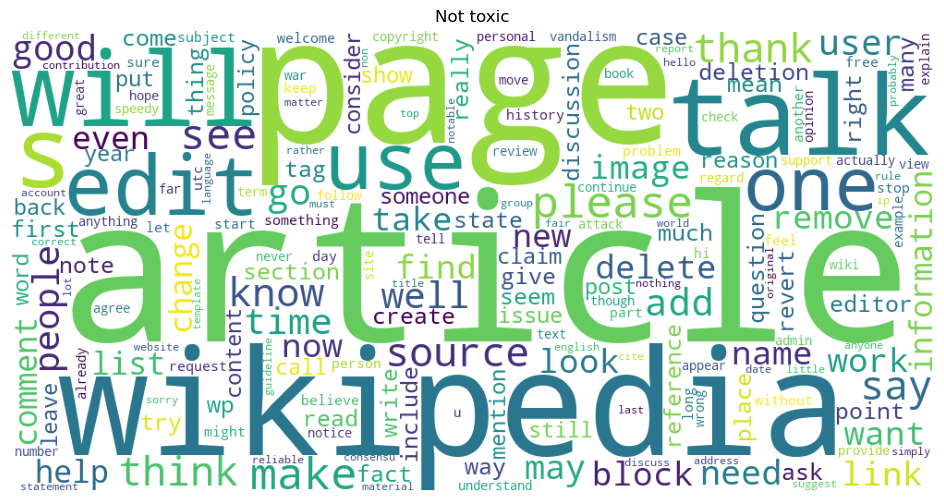

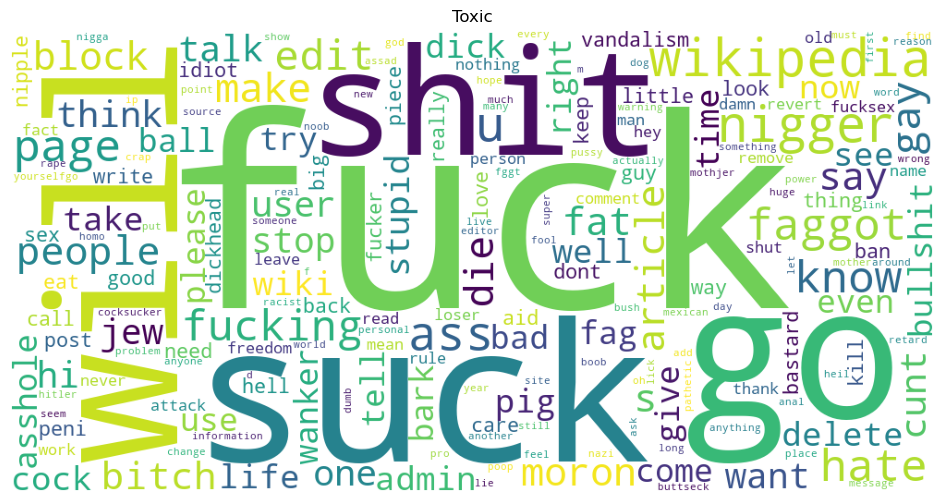

In [16]:
def show_wordcloud(series, title=None):
    text_blob = " ".join(series.dropna().astype(str).values)
    wc = WordCloud(
        width=1000, height=500,
        background_color="white",
        collocations=False,
        max_words=200
    ).generate(text_blob)

    plt.figure(figsize=(12, 6))
    plt.imshow(wc)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()

show_wordcloud(not_toxic_data["lemm_text"], "Not toxic")
show_wordcloud(toxic_data["lemm_text"], "Toxic")


Теперь у нас есть очищенный и леммантизированный текст. Оставим старый текст для последующего использования в CatBoost. 

Также оформим переменные для признаков и поделим их на тренировочную и обучающую выборки в соотношение 3:1.

In [17]:
# X = data[["lemm_text", "text"]]
# y = data["toxic"]

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.25, random_state=42, stratify=y
# )


In [18]:
X = data[["lemm_text", "text"]]
y = data["toxic"]

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.15, random_state=42, stratify=y_train_full
)

Также учтем стоп-слова, но не отрицания (могут быть полезны).

In [19]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

KEEP_NEG = {"no", "not", "never", "n't"}
stop_words = list(set(ENGLISH_STOP_WORDS) - KEEP_NEG)

Добавляем простые числовые признаки из raw-текста (длина, знаки !/?, доля капса/цифр, повторы символов). Эти признаки хорошо дополняют текстовую модель и часто помогают для токсичности.

In [20]:
import numpy as np
import pandas as pd
import re
from sklearn.preprocessing import FunctionTransformer
import scipy.sparse as sp

def text_stats_sparse(X):

    if isinstance(X, pd.DataFrame):
        s = X.iloc[:, 0]
    elif isinstance(X, pd.Series):
        s = X
    else:
        s = pd.Series(X.ravel())

    s = s.fillna("").astype(str)

    char_len = s.str.len()
    word_len = s.str.split().str.len()
    exclam = s.str.count(r"!")
    quest  = s.str.count(r"\?")
    upper_ratio = s.apply(lambda t: sum(c.isupper() for c in t) / max(len(t), 1))
    digit_ratio = s.apply(lambda t: sum(c.isdigit() for c in t) / max(len(t), 1))
    repeat_chars = s.str.count(r"(.)\1{2,}")

    arr = np.vstack([char_len, word_len, exclam, quest, upper_ratio, digit_ratio, repeat_chars]).T.astype(np.float32)
    return sp.csr_matrix(arr)


Теперь можем непосредственно перейти к обучению.

## Обучение

Рассмотрим 3 модели - LGBM, логистическую регрессию и CatBoost.

### LGBM

Сформируем функцию, которая считает метрики на валидации и подбирает порог вероятности, который максимизирует F1. Возвращается ROC-AUC, PR-AUC, лучший порог, F1 и матрица ошибок.

In [21]:
# import numpy as np
# from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, confusion_matrix

# def eval_on_val(model, X_val, y_val, n_thr=19):
#     proba = model.predict_proba(X_val)[:, 1]
#     roc = roc_auc_score(y_val, proba)
#     ap  = average_precision_score(y_val, proba)

#     ths = np.linspace(0.05, 0.95, n_thr)
#     best_th, best_f1 = max(
#         ((th, f1_score(y_val, (proba >= th).astype(int))) for th in ths),
#         key=lambda x: x[1]
#     )
#     cm = confusion_matrix(y_val, (proba >= best_th).astype(int))
#     return roc, ap, best_th, best_f1, cm


import numpy as np
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, confusion_matrix


def eval_model(model, X, y, n_thr=19):
    proba = model.predict_proba(X)[:, 1]

    roc = roc_auc_score(y, proba)
    ap  = average_precision_score(y, proba)

    ths = np.linspace(0.05, 0.95, n_thr)
    best_th, best_f1 = max(
        ((th, f1_score(y, (proba >= th).astype(int))) for th in ths),
        key=lambda x: x[1]
    )
    cm = confusion_matrix(y, (proba >= best_th).astype(int))
    return roc, ap, best_th, best_f1, cm


Время обучения считается как длительность вызова fit(). Это позволяет честно сравнивать модели по скорости на одинаковых данных.

In [22]:
import time

def fit_timed(model, X, y):
    t0 = time.perf_counter()
    model.fit(X, y)
    train_time = time.perf_counter() - t0
    return model, train_time


In [46]:
def accs_from_proba(y, proba, th):
    pred = (proba >= th).astype(int)
    return accuracy_score(y, pred), balanced_accuracy_score(y, pred)

Обучается LGBM на разреженных признаках: word TF-IDF по lemm_text, char TF-IDF по text и простые числовые статистики. Оценка проводится на X_val.

In [23]:
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from lightgbm import LGBMClassifier
from sklearn.preprocessing import FunctionTransformer, MaxAbsScaler

TEXT_WORD = "lemm_text"
TEXT_RAW  = "text"

preprocess = ColumnTransformer(
    transformers=[
        ("word", TfidfVectorizer(stop_words=stop_words, dtype=np.float32), TEXT_WORD),
        ("char", TfidfVectorizer(
            analyzer="char_wb",
            ngram_range=(3,4),
            min_df=3,
            max_features=50000,
            dtype=np.float32
        ), TEXT_RAW),
        ("stats", Pipeline([
            ("stats", FunctionTransformer(text_stats_sparse, validate=False)),
            ("scale", MaxAbsScaler())
        ]), TEXT_RAW),
    ],
    remainder="drop"
)

lgbm_model = Pipeline([
    ("prep", preprocess),
    ("model", LGBMClassifier(
        random_state=12345,
        class_weight="balanced",
        n_jobs=4,
        force_col_wise=True,
        verbosity=-1
    ))
]).set_params(
    model__n_estimators=600,
    model__learning_rate=0.05,
    model__num_leaves=63
)

#lgbm_model.fit(X_train, y_train)

lgbm_model, lgbm_time = fit_timed(lgbm_model, X_train, y_train)
lgbm_roc, lgbm_ap, lgbm_th, lgbm_f1, lgbm_cm = eval_model(lgbm_model, X_val, y_val)

print("LGBM VAL ROC-AUC:", lgbm_roc)
print("LGBM VAL PR-AUC:", lgbm_ap)
print("LGBM VAL best_th:", lgbm_th, "VAL F1:", lgbm_f1)
print("LGBM VAL CM:\n", lgbm_cm)
print("LGBM train_time_sec:", round(lgbm_time, 2))

D:\Conda\envs\nlp-gpu\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LGBM VAL ROC-AUC: 0.9770279451942657
LGBM VAL PR-AUC: 0.8952158553295544
LGBM VAL best_th: 0.7 VAL F1: 0.8050647820965842
LGBM VAL CM:
 [[15892   208]
 [  454  1367]]
LGBM train_time_sec: 2058.6


In [48]:
lgbm_proba = lgbm_model.predict_proba(X_val)[:, 1]
lgbm_acc, lgbm_bacc = accs_from_proba(y_val, lgbm_proba, lgbm_th)
print("LGBM VAL acc:", round(lgbm_acc, 4), "balanced_acc:", round(lgbm_bacc, 4))

D:\Conda\envs\nlp-gpu\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LGBM VAL acc: 0.9631 balanced_acc: 0.8689


In [25]:
from sklearn.metrics import classification_report

val_pred = (lgbm_model.predict_proba(X_val)[:, 1] >= lgbm_th).astype(int)
print(classification_report(y_val, val_pred, digits=4))


D:\Conda\envs\nlp-gpu\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0     0.9722    0.9871    0.9796     16100
           1     0.8679    0.7507    0.8051      1821

    accuracy                         0.9631     17921
   macro avg     0.9201    0.8689    0.8923     17921
weighted avg     0.9616    0.9631    0.9619     17921



LGBM (word+char TF-IDF + stats, train→val): ROC-AUC = 0.977, PR-AUC = 0.895.
Подбор порога по F1 на валидации дал threshold = 0.70, F1 = 0.805.
На классе toxic: precision = 0.868, recall = 0.751 (смещение в сторону меньшего числа FP, ценой FN).
Далее сравниваем с логистический регрессией и кэтбустом.

### Логистическая регрессия

Логистическая регрессия обычно даёт сильный бейзлайн на TF-IDF. Подбирается только параметр C (регуляризация), чтобы не делать долгий подбор гиперпараметров.

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

best_lr = None
best_lr_f1 = -1

for C in [0.5, 1.0, 2.0]:
    lr_model = Pipeline([
        ("prep", preprocess),
        ("model", LogisticRegression(
            class_weight="balanced",
            solver="saga",
            C=C,
            max_iter=2000
        ))
    ])

    lr_model, lr_time = fit_timed(lr_model, X_train, y_train)
    roc, ap, th, f1, cm = eval_model(lr_model, X_val, y_val)

    print(f"C={C} | VAL F1={f1:.4f} | ROC={roc:.4f} | AP={ap:.4f} | th={th:.2f}")

    if f1 > best_lr_f1:
        best_lr_f1 = f1
        best_lr = (lr_model, lr_time, roc, ap, th, f1, cm)

best_lr_model, best_lr_time, lr_roc, lr_ap, lr_th, lr_f1, lr_cm = best_lr

print("\nBEST LR:")
print("LR VAL ROC-AUC:", lr_roc)
print("LR VAL PR-AUC:", lr_ap)
print("LR VAL best_th:", lr_th, "VAL F1:", lr_f1)
print("LR VAL CM:\n", lr_cm)
print("BEST LR time_sec:", round(best_lr_time, 2))


C=0.5 | VAL F1=0.8076 | ROC=0.9782 | AP=0.8939 | th=0.75
C=1.0 | VAL F1=0.8128 | ROC=0.9785 | AP=0.8968 | th=0.70
C=2.0 | VAL F1=0.8151 | ROC=0.9780 | AP=0.8972 | th=0.70

BEST LR:
LR VAL ROC-AUC: 0.9779797804086896
LR VAL PR-AUC: 0.8971561833259776
LR VAL best_th: 0.7 VAL F1: 0.8150646430578977
LR VAL CM:
 [[15813   287]
 [  371  1450]]
BEST LR time_sec: 122.43


In [49]:
lr_proba = best_lr_model.predict_proba(X_val)[:, 1]
lr_acc, lr_bacc = accs_from_proba(y_val, lr_proba, lr_th)
print("LR VAL acc:", round(lr_acc, 4), "balanced_acc:", round(lr_bacc, 4))

LR VAL acc: 0.9633 balanced_acc: 0.8892


In [27]:
val_pred = (lr_model.predict_proba(X_val)[:, 1] >= lr_th).astype(int)
print(classification_report(y_val, val_pred, digits=4))


              precision    recall  f1-score   support

           0     0.9771    0.9822    0.9796     16100
           1     0.8348    0.7963    0.8151      1821

    accuracy                         0.9633     17921
   macro avg     0.9059    0.8892    0.8973     17921
weighted avg     0.9626    0.9633    0.9629     17921



LogReg (word+char TF-IDF + stats, train→val): лучший результат на валидации при C=2.0 (порог 0.70): F1 = 0.815, ROC-AUC ≈ 0.978, PR-AUC ≈ 0.897.
По сравнению с LGBM модель обучается значительно быстрее и даёт немного более высокий F1 на валидации. Это делает ее сильным и практичным бейзлайном для текстовой классификации на TF-IDF.

### CatBoost

Ранее мы уже считали такие же статистические признаки в `text_stats_sparse()` для sklearn-пайплайна (LGBM/LogReg), где нужен csr_matrix.
Здесь повторяем тот же набор признаков, но возвращаем их как обычные числовые колонки DataFrame, потому что кэтбуст удобнее обучать на табличных колонках + text_features (встроенная работа с текстом).

In [28]:
def add_text_stats_df(X, col="text"):
    X = X.copy()
    s = X[col].fillna("").astype(str)

    X["char_len"] = s.str.len().astype(np.float32)
    X["word_len"] = s.str.split().str.len().astype(np.float32)
    X["exclam"] = s.str.count(r"!").astype(np.float32)
    X["quest"]  = s.str.count(r"\?").astype(np.float32)

    denom = X["char_len"].replace(0, 1.0).astype(np.float32)
    X["upper_ratio"] = (s.str.count(r"[A-Z]").astype(np.float32) / denom).astype(np.float32)
    X["digit_ratio"] = (s.str.count(r"\d").astype(np.float32) / denom).astype(np.float32)

    X["repeat_chars"] = s.str.count(r"(.)\1{2,}").astype(np.float32)
    return X


Готовим таблицу для кэтбуста: оставляем два текстовых поля (lemm_text, text) и добавляем числовые stats. Кэтбуст будет сам извлекать признаки из текстовых колонок через text_features.

In [32]:
from catboost import Pool

text_cols = ["lemm_text", "text"]  # оба текста можно давать как text_features

X_train_cb = add_text_stats_df(X_train, col="text")
X_val_cb   = add_text_stats_df(X_val, col="text")

train_pool = Pool(X_train_cb, y_train, text_features=text_cols)
val_pool   = Pool(X_val_cb,   y_val,   text_features=text_cols)

Собираем Pool — нативный формат CatBoost. В нём явно указываем, какие колонки являются текстовыми (text_features), чтобы CatBoost применил встроенный текстовый препроцессинг.
Обучаем CatBoost с early stopping на валидации (eval_set). 

Для CatBoost также пробуем использование GPU, потому что модель работает со встроенными text_features (сырые текстовые колонки) и не строит огромную sparse TF-IDF матрицу.

CatBoost grid_search не принимает внешний eval_set, поэтому делаем небольшой перебор гиперпараметров вручную, но в “sklearn-стиле”: генерируем комбинации через ParameterGrid, обучаем каждую модель с early stopping на фиксированной валидации и сравниваем по F1 (порог подбираем отдельно).

In [55]:
from catboost import CatBoostClassifier
from sklearn.model_selection import ParameterGrid

grid = {
    "depth": [4, 6, 8],
    "l2_leaf_reg": [3, 10, 20],
    "random_strength": [1, 5],
}

# grid = {
#     "depth": [6, 8],
#     "l2_leaf_reg": [3, 10],
#     "random_strength": [1, 5],
# }

base_params = dict(
    iterations=3000,
    learning_rate=0.05,
    loss_function="Logloss",
    eval_metric="Logloss",
    auto_class_weights="Balanced",
    random_seed=12345,
    verbose=200,
    od_type="Iter",
    od_wait=100,
    task_type="GPU",
    devices="0",
)

best_cat_time = None
best_cat_model = None
best_cat_f1 = -1
best_cat_metrics = None
best_cat_cfg = None

for cfg in ParameterGrid(grid):
    cat = CatBoostClassifier(**base_params, **cfg)
    t0 = time.perf_counter()
    cat.fit(train_pool, eval_set=val_pool, use_best_model=True, plot=True)
    cat_time = time.perf_counter() - t0
    roc, ap, th, f1, cm = eval_model(cat, val_pool, y_val)
    print(f"{cfg} | VAL F1={f1:.4f} | ROC={roc:.4f} | AP={ap:.4f} | th={th:.2f}")

    if f1 > best_cat_f1:
        best_cat_f1 = f1
        best_cat_time = cat_time
        best_cat_model = cat
        best_cat_metrics = (roc, ap, th, f1, cm)
        best_cat_cfg = cfg

cat_roc, cat_ap, cat_th, cat_f1, cat_cm = best_cat_metrics

print("\nBEST CAT:", best_cat_cfg)
print("CAT VAL ROC-AUC:", cat_roc)
print("CAT VAL PR-AUC:", cat_ap)
print("CAT VAL best_th:", cat_th, "VAL F1:", cat_f1)
print("CAT VAL CM:\n", cat_cm)
print("CAT train_time_sec:", round(best_cat_time, 2))


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6444694	test: 0.6431588	best: 0.6431588 (0)	total: 172ms	remaining: 8m 34s
200:	learn: 0.2442365	test: 0.2385128	best: 0.2385128 (200)	total: 6.67s	remaining: 1m 32s
400:	learn: 0.2248250	test: 0.2266855	best: 0.2266826 (399)	total: 12.1s	remaining: 1m 18s
600:	learn: 0.2120362	test: 0.2204571	best: 0.2204571 (600)	total: 18.4s	remaining: 1m 13s
800:	learn: 0.2025478	test: 0.2172260	best: 0.2172260 (800)	total: 24.4s	remaining: 1m 6s
1000:	learn: 0.1945639	test: 0.2148781	best: 0.2148781 (1000)	total: 30.4s	remaining: 1m
1200:	learn: 0.1876289	test: 0.2130852	best: 0.2130707 (1198)	total: 36.4s	remaining: 54.5s
1400:	learn: 0.1813249	test: 0.2117679	best: 0.2117499 (1398)	total: 42.4s	remaining: 48.4s
1600:	learn: 0.1757932	test: 0.2109925	best: 0.2109212 (1545)	total: 49s	remaining: 42.8s
1800:	learn: 0.1706602	test: 0.2103575	best: 0.2103528 (1786)	total: 54.2s	remaining: 36.1s
2000:	learn: 0.1657188	test: 0.2096393	best: 0.2095273 (1974)	total: 1m	remaining: 30s
2200:	le

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6537242	test: 0.6528372	best: 0.6528372 (0)	total: 190ms	remaining: 9m 28s
200:	learn: 0.2461797	test: 0.2396230	best: 0.2396230 (200)	total: 6.84s	remaining: 1m 35s
400:	learn: 0.2255608	test: 0.2262574	best: 0.2262562 (399)	total: 12.7s	remaining: 1m 22s
600:	learn: 0.2128122	test: 0.2209237	best: 0.2209237 (600)	total: 18.4s	remaining: 1m 13s
800:	learn: 0.2029775	test: 0.2172341	best: 0.2172341 (800)	total: 23.5s	remaining: 1m 4s
1000:	learn: 0.1948567	test: 0.2147827	best: 0.2147827 (1000)	total: 28.8s	remaining: 57.5s
1200:	learn: 0.1877107	test: 0.2130900	best: 0.2130507 (1170)	total: 33.6s	remaining: 50.3s
1400:	learn: 0.1813306	test: 0.2117278	best: 0.2117278 (1400)	total: 39.4s	remaining: 44.9s
1600:	learn: 0.1755171	test: 0.2107540	best: 0.2107421 (1599)	total: 44.8s	remaining: 39.1s
1800:	learn: 0.1702665	test: 0.2101291	best: 0.2100248 (1737)	total: 50s	remaining: 33.3s
2000:	learn: 0.1654798	test: 0.2093520	best: 0.2092000 (1972)	total: 56.2s	remaining: 28.1s


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6450656	test: 0.6437663	best: 0.6437663 (0)	total: 169ms	remaining: 8m 25s
200:	learn: 0.2447736	test: 0.2387726	best: 0.2387726 (200)	total: 6.14s	remaining: 1m 25s
400:	learn: 0.2262567	test: 0.2269247	best: 0.2269234 (399)	total: 12.4s	remaining: 1m 20s
600:	learn: 0.2138954	test: 0.2209407	best: 0.2209407 (600)	total: 17.9s	remaining: 1m 11s
800:	learn: 0.2048611	test: 0.2173502	best: 0.2173502 (800)	total: 23.6s	remaining: 1m 4s
1000:	learn: 0.1971008	test: 0.2147487	best: 0.2147487 (1000)	total: 28.6s	remaining: 57s
1200:	learn: 0.1905310	test: 0.2129525	best: 0.2129413 (1198)	total: 34.5s	remaining: 51.6s
1400:	learn: 0.1849055	test: 0.2119282	best: 0.2119282 (1400)	total: 40.8s	remaining: 46.6s
1600:	learn: 0.1795521	test: 0.2107300	best: 0.2107300 (1600)	total: 47.3s	remaining: 41.4s
1800:	learn: 0.1747346	test: 0.2098561	best: 0.2098561 (1800)	total: 53.6s	remaining: 35.7s
2000:	learn: 0.1704025	test: 0.2091535	best: 0.2090971 (1972)	total: 59.6s	remaining: 29.8s


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6537357	test: 0.6528445	best: 0.6528445 (0)	total: 169ms	remaining: 8m 25s
200:	learn: 0.2462759	test: 0.2396103	best: 0.2396103 (200)	total: 7.19s	remaining: 1m 40s
400:	learn: 0.2264596	test: 0.2268106	best: 0.2268092 (399)	total: 13.2s	remaining: 1m 25s
600:	learn: 0.2142830	test: 0.2210134	best: 0.2210134 (600)	total: 17.8s	remaining: 1m 11s
800:	learn: 0.2051568	test: 0.2175750	best: 0.2175750 (800)	total: 20.3s	remaining: 55.8s
1000:	learn: 0.1977053	test: 0.2152071	best: 0.2152071 (1000)	total: 23.9s	remaining: 47.8s
1200:	learn: 0.1907944	test: 0.2129687	best: 0.2129591 (1199)	total: 28s	remaining: 42s
1400:	learn: 0.1848369	test: 0.2118312	best: 0.2118312 (1400)	total: 33.1s	remaining: 37.8s
1600:	learn: 0.1795536	test: 0.2105493	best: 0.2105367 (1597)	total: 38.8s	remaining: 33.9s
1800:	learn: 0.1748072	test: 0.2101626	best: 0.2101560 (1789)	total: 45.4s	remaining: 30.2s
2000:	learn: 0.1704649	test: 0.2094352	best: 0.2094202 (1996)	total: 51.5s	remaining: 25.7s
22

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6456847	test: 0.6444093	best: 0.6444093 (0)	total: 162ms	remaining: 8m 5s
200:	learn: 0.2453142	test: 0.2390833	best: 0.2390833 (200)	total: 7s	remaining: 1m 37s
400:	learn: 0.2267403	test: 0.2272682	best: 0.2272674 (399)	total: 12.7s	remaining: 1m 22s
600:	learn: 0.2154002	test: 0.2217262	best: 0.2217262 (600)	total: 18.2s	remaining: 1m 12s
800:	learn: 0.2066843	test: 0.2177867	best: 0.2177867 (800)	total: 23.7s	remaining: 1m 5s
1000:	learn: 0.1996993	test: 0.2156408	best: 0.2156408 (1000)	total: 30.1s	remaining: 1m
1200:	learn: 0.1934755	test: 0.2141601	best: 0.2141411 (1198)	total: 36.6s	remaining: 54.8s
1400:	learn: 0.1881678	test: 0.2131036	best: 0.2130283 (1376)	total: 42.3s	remaining: 48.3s
1600:	learn: 0.1831895	test: 0.2119418	best: 0.2119388 (1597)	total: 48.2s	remaining: 42.1s
1800:	learn: 0.1788063	test: 0.2110922	best: 0.2110922 (1800)	total: 54.7s	remaining: 36.4s
2000:	learn: 0.1747139	test: 0.2102409	best: 0.2102261 (1999)	total: 1m	remaining: 30.4s
2200:	le

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6537550	test: 0.6528568	best: 0.6528568 (0)	total: 175ms	remaining: 8m 43s
200:	learn: 0.2466791	test: 0.2394995	best: 0.2394995 (200)	total: 6.88s	remaining: 1m 35s
400:	learn: 0.2272498	test: 0.2263861	best: 0.2263742 (399)	total: 13.4s	remaining: 1m 26s
600:	learn: 0.2154624	test: 0.2207217	best: 0.2207217 (600)	total: 19.7s	remaining: 1m 18s
800:	learn: 0.2065698	test: 0.2168417	best: 0.2168417 (800)	total: 26.4s	remaining: 1m 12s
1000:	learn: 0.1992956	test: 0.2144871	best: 0.2144871 (1000)	total: 32.3s	remaining: 1m 4s
1200:	learn: 0.1934001	test: 0.2130166	best: 0.2129952 (1198)	total: 38.6s	remaining: 57.8s
1400:	learn: 0.1880273	test: 0.2118234	best: 0.2118170 (1385)	total: 44.5s	remaining: 50.8s
1600:	learn: 0.1829387	test: 0.2106672	best: 0.2106672 (1600)	total: 50.6s	remaining: 44.2s
1800:	learn: 0.1783257	test: 0.2100166	best: 0.2100166 (1800)	total: 56.9s	remaining: 37.9s
2000:	learn: 0.1743062	test: 0.2092699	best: 0.2092574 (1999)	total: 1m 3s	remaining: 31.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6408852	test: 0.6396143	best: 0.6396143 (0)	total: 231ms	remaining: 11m 34s
200:	learn: 0.2271867	test: 0.2281423	best: 0.2281423 (200)	total: 6.86s	remaining: 1m 35s
400:	learn: 0.2040518	test: 0.2188720	best: 0.2188720 (400)	total: 13.1s	remaining: 1m 25s
600:	learn: 0.1882925	test: 0.2145561	best: 0.2145561 (600)	total: 19.1s	remaining: 1m 16s
800:	learn: 0.1764353	test: 0.2124663	best: 0.2124663 (800)	total: 23.8s	remaining: 1m 5s
1000:	learn: 0.1661753	test: 0.2113982	best: 0.2113830 (997)	total: 30.6s	remaining: 1m 1s
1200:	learn: 0.1573424	test: 0.2103754	best: 0.2102955 (1191)	total: 37.9s	remaining: 56.7s
1400:	learn: 0.1498388	test: 0.2098129	best: 0.2096726 (1341)	total: 44s	remaining: 50.2s
bestTest = 0.2096725726
bestIteration = 1341
Shrink model to first 1342 iterations.
{'depth': 6, 'l2_leaf_reg': 3, 'random_strength': 1} | VAL F1=0.7901 | ROC=0.9738 | AP=0.8812 | th=0.85


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6418666	test: 0.6406807	best: 0.6406807 (0)	total: 218ms	remaining: 10m 53s
200:	learn: 0.2299633	test: 0.2306190	best: 0.2306190 (200)	total: 7.91s	remaining: 1m 50s
400:	learn: 0.2058738	test: 0.2196255	best: 0.2196255 (400)	total: 14.5s	remaining: 1m 34s
600:	learn: 0.1897885	test: 0.2144960	best: 0.2144960 (600)	total: 21.5s	remaining: 1m 25s
800:	learn: 0.1777242	test: 0.2119333	best: 0.2118837 (790)	total: 28.7s	remaining: 1m 18s
1000:	learn: 0.1672712	test: 0.2102539	best: 0.2102539 (1000)	total: 36s	remaining: 1m 11s
1200:	learn: 0.1582490	test: 0.2094301	best: 0.2093533 (1192)	total: 42.8s	remaining: 1m 4s
1400:	learn: 0.1508307	test: 0.2089256	best: 0.2087632 (1331)	total: 50s	remaining: 57s
bestTest = 0.2087632257
bestIteration = 1331
Shrink model to first 1332 iterations.
{'depth': 6, 'l2_leaf_reg': 3, 'random_strength': 5} | VAL F1=0.7869 | ROC=0.9742 | AP=0.8813 | th=0.80


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6417918	test: 0.6405324	best: 0.6405324 (0)	total: 234ms	remaining: 11m 40s
200:	learn: 0.2288312	test: 0.2287204	best: 0.2287204 (200)	total: 7.97s	remaining: 1m 50s
400:	learn: 0.2071658	test: 0.2191022	best: 0.2191022 (400)	total: 13.7s	remaining: 1m 28s
600:	learn: 0.1926021	test: 0.2145618	best: 0.2145618 (600)	total: 20.3s	remaining: 1m 21s
800:	learn: 0.1815148	test: 0.2120710	best: 0.2120710 (800)	total: 27s	remaining: 1m 14s
1000:	learn: 0.1723290	test: 0.2104665	best: 0.2104368 (997)	total: 33.5s	remaining: 1m 6s
1200:	learn: 0.1640454	test: 0.2091243	best: 0.2090660 (1196)	total: 40.3s	remaining: 1m
1400:	learn: 0.1574693	test: 0.2084059	best: 0.2083850 (1391)	total: 47s	remaining: 53.6s
bestTest = 0.2079948316
bestIteration = 1445
Shrink model to first 1446 iterations.
{'depth': 6, 'l2_leaf_reg': 10, 'random_strength': 1} | VAL F1=0.7858 | ROC=0.9744 | AP=0.8812 | th=0.80


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6430804	test: 0.6419274	best: 0.6419274 (0)	total: 213ms	remaining: 10m 39s
200:	learn: 0.2313597	test: 0.2304651	best: 0.2304651 (200)	total: 7.14s	remaining: 1m 39s
400:	learn: 0.2083709	test: 0.2191978	best: 0.2191978 (400)	total: 13.9s	remaining: 1m 30s
600:	learn: 0.1933274	test: 0.2142958	best: 0.2142958 (600)	total: 20.5s	remaining: 1m 21s
800:	learn: 0.1820924	test: 0.2114481	best: 0.2114124 (788)	total: 25s	remaining: 1m 8s
1000:	learn: 0.1726241	test: 0.2092971	best: 0.2092971 (1000)	total: 29.6s	remaining: 59.1s
1200:	learn: 0.1645361	test: 0.2081847	best: 0.2081673 (1196)	total: 35.7s	remaining: 53.5s
1400:	learn: 0.1575156	test: 0.2073354	best: 0.2073134 (1394)	total: 41s	remaining: 46.8s
bestTest = 0.2072917353
bestIteration = 1402
Shrink model to first 1403 iterations.
{'depth': 6, 'l2_leaf_reg': 10, 'random_strength': 5} | VAL F1=0.7877 | ROC=0.9746 | AP=0.8816 | th=0.80


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6425903	test: 0.6413556	best: 0.6413556 (0)	total: 206ms	remaining: 10m 18s
200:	learn: 0.2295757	test: 0.2289359	best: 0.2289359 (200)	total: 7.08s	remaining: 1m 38s
400:	learn: 0.2091277	test: 0.2195805	best: 0.2195805 (400)	total: 13.7s	remaining: 1m 28s
600:	learn: 0.1952263	test: 0.2149460	best: 0.2149460 (600)	total: 20.6s	remaining: 1m 22s
800:	learn: 0.1847988	test: 0.2122713	best: 0.2122713 (800)	total: 28s	remaining: 1m 16s
1000:	learn: 0.1763419	test: 0.2110167	best: 0.2110167 (1000)	total: 35.5s	remaining: 1m 10s
1200:	learn: 0.1688063	test: 0.2098996	best: 0.2098996 (1200)	total: 42.9s	remaining: 1m 4s
1400:	learn: 0.1624541	test: 0.2087870	best: 0.2087870 (1400)	total: 50.1s	remaining: 57.1s
bestTest = 0.2084781051
bestIteration = 1489
Shrink model to first 1490 iterations.
{'depth': 6, 'l2_leaf_reg': 20, 'random_strength': 1} | VAL F1=0.7888 | ROC=0.9741 | AP=0.8804 | th=0.85


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6439380	test: 0.6428066	best: 0.6428066 (0)	total: 215ms	remaining: 10m 43s
200:	learn: 0.2319485	test: 0.2299310	best: 0.2299310 (200)	total: 7.36s	remaining: 1m 42s
400:	learn: 0.2101762	test: 0.2189767	best: 0.2189767 (400)	total: 13.6s	remaining: 1m 28s
600:	learn: 0.1960284	test: 0.2140985	best: 0.2140985 (600)	total: 20.6s	remaining: 1m 22s
800:	learn: 0.1854357	test: 0.2113285	best: 0.2113112 (795)	total: 27.3s	remaining: 1m 14s
1000:	learn: 0.1768081	test: 0.2095795	best: 0.2095753 (997)	total: 32.8s	remaining: 1m 5s
1200:	learn: 0.1691731	test: 0.2081416	best: 0.2080906 (1193)	total: 39.1s	remaining: 58.6s
1400:	learn: 0.1628950	test: 0.2075051	best: 0.2074994 (1331)	total: 46.4s	remaining: 53s
1600:	learn: 0.1571086	test: 0.2070336	best: 0.2069398 (1569)	total: 53.2s	remaining: 46.5s
bestTest = 0.206939846
bestIteration = 1569
Shrink model to first 1570 iterations.
{'depth': 6, 'l2_leaf_reg': 20, 'random_strength': 5} | VAL F1=0.7910 | ROC=0.9746 | AP=0.8820 | th=

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6373304	test: 0.6360994	best: 0.6360994 (0)	total: 293ms	remaining: 14m 38s
200:	learn: 0.2107952	test: 0.2244073	best: 0.2244073 (200)	total: 8.48s	remaining: 1m 58s
400:	learn: 0.1829549	test: 0.2160097	best: 0.2160097 (400)	total: 15.4s	remaining: 1m 39s
600:	learn: 0.1645014	test: 0.2141714	best: 0.2141451 (596)	total: 21s	remaining: 1m 23s
800:	learn: 0.1504239	test: 0.2137226	best: 0.2135072 (791)	total: 27.3s	remaining: 1m 15s
bestTest = 0.2135072337
bestIteration = 791
Shrink model to first 792 iterations.
{'depth': 8, 'l2_leaf_reg': 3, 'random_strength': 1} | VAL F1=0.7860 | ROC=0.9729 | AP=0.8794 | th=0.85


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6405650	test: 0.6394592	best: 0.6394592 (0)	total: 317ms	remaining: 15m 51s
200:	learn: 0.2140298	test: 0.2261946	best: 0.2261946 (200)	total: 6.42s	remaining: 1m 29s
400:	learn: 0.1856194	test: 0.2174720	best: 0.2174720 (400)	total: 14.8s	remaining: 1m 35s
600:	learn: 0.1663867	test: 0.2145969	best: 0.2144994 (548)	total: 23.1s	remaining: 1m 32s
800:	learn: 0.1521960	test: 0.2134642	best: 0.2132986 (782)	total: 30.7s	remaining: 1m 24s
bestTest = 0.2132985568
bestIteration = 782
Shrink model to first 783 iterations.
{'depth': 8, 'l2_leaf_reg': 3, 'random_strength': 5} | VAL F1=0.7855 | ROC=0.9732 | AP=0.8790 | th=0.85


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6390639	test: 0.6378321	best: 0.6378321 (0)	total: 325ms	remaining: 16m 14s
200:	learn: 0.2142133	test: 0.2237942	best: 0.2237942 (200)	total: 9.07s	remaining: 2m 6s
400:	learn: 0.1886052	test: 0.2151501	best: 0.2151501 (400)	total: 14.9s	remaining: 1m 36s
600:	learn: 0.1716945	test: 0.2121447	best: 0.2121418 (594)	total: 20.8s	remaining: 1m 22s
800:	learn: 0.1589399	test: 0.2103475	best: 0.2103274 (795)	total: 28.8s	remaining: 1m 19s
1000:	learn: 0.1483345	test: 0.2098669	best: 0.2097927 (933)	total: 36.4s	remaining: 1m 12s
1200:	learn: 0.1394138	test: 0.2100378	best: 0.2095744 (1119)	total: 43.7s	remaining: 1m 5s
bestTest = 0.2095744136
bestIteration = 1119
Shrink model to first 1120 iterations.
{'depth': 8, 'l2_leaf_reg': 10, 'random_strength': 1} | VAL F1=0.7900 | ROC=0.9741 | AP=0.8824 | th=0.85


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6419205	test: 0.6408598	best: 0.6408598 (0)	total: 245ms	remaining: 12m 14s
200:	learn: 0.2172950	test: 0.2254781	best: 0.2254641 (199)	total: 8.67s	remaining: 2m
400:	learn: 0.1906459	test: 0.2155778	best: 0.2155778 (400)	total: 17s	remaining: 1m 50s
600:	learn: 0.1730714	test: 0.2119045	best: 0.2119045 (600)	total: 25.6s	remaining: 1m 42s
800:	learn: 0.1599979	test: 0.2099317	best: 0.2099141 (796)	total: 33.9s	remaining: 1m 33s
1000:	learn: 0.1491076	test: 0.2096577	best: 0.2093044 (941)	total: 42.1s	remaining: 1m 23s
bestTest = 0.2093044119
bestIteration = 941
Shrink model to first 942 iterations.
{'depth': 8, 'l2_leaf_reg': 10, 'random_strength': 5} | VAL F1=0.7875 | ROC=0.9740 | AP=0.8818 | th=0.80


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6402954	test: 0.6390895	best: 0.6390895 (0)	total: 283ms	remaining: 14m 7s
200:	learn: 0.2161734	test: 0.2232912	best: 0.2232912 (200)	total: 8.88s	remaining: 2m 3s
400:	learn: 0.1919260	test: 0.2150023	best: 0.2150023 (400)	total: 16.3s	remaining: 1m 45s
600:	learn: 0.1764339	test: 0.2118236	best: 0.2118236 (600)	total: 24.2s	remaining: 1m 36s
800:	learn: 0.1649568	test: 0.2100051	best: 0.2099750 (781)	total: 32.1s	remaining: 1m 28s
1000:	learn: 0.1551856	test: 0.2088215	best: 0.2087889 (996)	total: 38.8s	remaining: 1m 17s
1200:	learn: 0.1468729	test: 0.2088508	best: 0.2086689 (1129)	total: 46.5s	remaining: 1m 9s
bestTest = 0.2086689488
bestIteration = 1129
Shrink model to first 1130 iterations.
{'depth': 8, 'l2_leaf_reg': 20, 'random_strength': 1} | VAL F1=0.7877 | ROC=0.9741 | AP=0.8824 | th=0.80


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6428856	test: 0.6418558	best: 0.6418558 (0)	total: 414ms	remaining: 20m 41s
200:	learn: 0.2185122	test: 0.2248454	best: 0.2248454 (200)	total: 7.19s	remaining: 1m 40s
400:	learn: 0.1940729	test: 0.2145984	best: 0.2145984 (400)	total: 12.9s	remaining: 1m 23s
600:	learn: 0.1775670	test: 0.2111028	best: 0.2110841 (597)	total: 18.6s	remaining: 1m 14s
800:	learn: 0.1655429	test: 0.2096864	best: 0.2096076 (784)	total: 24.5s	remaining: 1m 7s
1000:	learn: 0.1559218	test: 0.2087632	best: 0.2087589 (993)	total: 30.3s	remaining: 1m
1200:	learn: 0.1476699	test: 0.2082143	best: 0.2081615 (1180)	total: 36.2s	remaining: 54.2s
1400:	learn: 0.1405441	test: 0.2079596	best: 0.2077748 (1343)	total: 42.6s	remaining: 48.6s
bestTest = 0.2077747814
bestIteration = 1343
Shrink model to first 1344 iterations.
{'depth': 8, 'l2_leaf_reg': 20, 'random_strength': 5} | VAL F1=0.7904 | ROC=0.9746 | AP=0.8836 | th=0.85

BEST CAT: {'depth': 6, 'l2_leaf_reg': 20, 'random_strength': 5}
CAT VAL ROC-AUC: 0.9745

Снова выведем метрики.

In [56]:
cat_proba = best_cat_model.predict_proba(val_pool)[:, 1]
cat_acc, cat_bacc = accs_from_proba(y_val, cat_proba, cat_th)
print("CAT VAL acc:", round(cat_acc, 4), "balanced_acc:", round(cat_bacc, 4))

CAT VAL acc: 0.9583 balanced_acc: 0.8777


In [57]:
val_proba_cb = best_cat_model.predict_proba(val_pool)[:, 1]
val_pred_cb  = (val_proba_cb >= cat_th).astype(int)

print(classification_report(y_val, val_pred_cb, digits=4))


              precision    recall  f1-score   support

           0     0.9748    0.9789    0.9768     16100
           1     0.8062    0.7765    0.7910      1821

    accuracy                         0.9583     17921
   macro avg     0.8905    0.8777    0.8839     17921
weighted avg     0.9577    0.9583    0.9580     17921



CatBoost был обучен на GPU с двумя текстовыми колонками (lemm_text, text) и добавленными числовыми статистиками. В ходе перебора небольшой сетки гиперпараметров лучшей оказалась конфигурация depth=6, l2_leaf_reg=20, random_strength=5; за счёт early stopping модель остановилась примерно на 1344 итерации. На валидации получены ROC-AUC=0.9746, PR-AUC=0.8820, оптимальный порог th=0.80 даёт F1=0.7910 (accuracy 0.9583, balanced accuracy 0.8777). Время обучения лучшей конфигурации составило ≈86 c.

### Dummy

Для сравнения также рассмотрим константую дамми-модель.

In [52]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score

# def eval_dummy(name, clf):
#     clf.fit(X_train_full, y_train_full)
#     pred = clf.predict(X_val)

#     print(f"\n{name}")
#     print("accuracy:", round(accuracy_score(y_val, pred), 4))
#     print("balanced_acc:", round(balanced_accuracy_score(y_val, pred), 4))
#     print("f1:", round(f1_score(y_val, pred), 4))
#     print("CM:\n", confusion_matrix(y_val, pred))

# eval_dummy("most_frequent", DummyClassifier(strategy="most_frequent", random_state=42))
# eval_dummy("stratified",    DummyClassifier(strategy="stratified", random_state=42))
# eval_dummy("always_0",      DummyClassifier(strategy="constant", constant=0, random_state=42))
# eval_dummy("always_1",      DummyClassifier(strategy="constant", constant=1, random_state=42))

def eval_dummy_row(name, clf):
    t0 = time.perf_counter()
    clf.fit(X_train_full, y_train_full)
    train_time = time.perf_counter() - t0

    pred = clf.predict(X_val)
    return {
        "model": f"Dummy ({name})",
        "val_f1": f1_score(y_val, pred),
        "val_roc_auc": np.nan,
        "val_pr_auc": np.nan,
        "best_th": np.nan,
        "train_time_sec": train_time,
        "val_acc": accuracy_score(y_val, pred),
        "val_bal_acc": balanced_accuracy_score(y_val, pred),
    }

dummy = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_row = eval_dummy_row(dummy.strategy, dummy)

Dummy-бейзлайны показывает минимальное качество: из-за дисбаланса классов стратегии always_0/most_frequent дают высокую accuracy, но F1=0 по toxic, а always_1/stratified дают ненулевой F1 ценой большого числа ошибок; следовательно, содержательные модели действительно учатся извлекать сигнал из текста.

### Сравнительная таблица моделей

In [58]:
# comparison_table = pd.DataFrame({'Название модели': ['LGBM', 'Linear', 'CatBoost', 'Dummy'], 'F1': [lgbm_best_score, log_reg_best_score, cat_best_score, dummy_score], 'Время обучения (в сек)': [113, 26, 150, 0.005]})
# comparison_table

summary = pd.DataFrame([
    {
        "model": "LogReg (TF-IDF word+char+stats)",
        "val_f1": lr_f1,
        "val_roc_auc": lr_roc,
        "val_pr_auc": lr_ap,
        "best_th": lr_th,
        "val_acc": lr_acc,
        "val_bal_acc": lr_bacc,
        "train_time_sec": best_lr_time
    },
    {
        "model": "LGBM (TF-IDF word+char+stats)",
        "val_f1": lgbm_f1,
        "val_roc_auc": lgbm_roc,
        "val_pr_auc": lgbm_ap,
        "best_th": lgbm_th,
        "val_acc": lgbm_acc,
        "val_bal_acc": lgbm_bacc,
        "train_time_sec": lgbm_time
    },
    {
        "model": "CatBoost (text_features, GPU)",
        "val_f1": cat_f1,
        "val_roc_auc": cat_roc,
        "val_pr_auc": cat_ap,
        "best_th": cat_th,
        "val_acc": cat_acc,
        "val_bal_acc": cat_bacc,
        "train_time_sec": best_cat_time
    },
    dummy_row
])

summary = summary.sort_values("val_f1", ascending=False).reset_index(drop=True)

for col in ["val_f1","val_roc_auc","val_pr_auc","best_th","train_time_sec","val_acc","val_bal_acc"]:
    if col in summary.columns:
        summary[col] = pd.to_numeric(summary[col], errors="coerce").round(4)

summary

,model,val_f1,val_roc_auc,val_pr_auc,best_th,val_acc,val_bal_acc,train_time_sec
0,LogReg (TF-IDF word+char+stats),0.8151,0.9780,0.8972,0.7,0.9633,0.8892,122.4269
1,LGBM (TF-IDF word+char+stats),0.8051,0.9770,0.8952,0.7,0.9631,0.8689,2058.6022
2,"CatBoost (text_features, GPU)",0.7910,0.9746,0.8820,0.8,0.9583,0.8777,86.3130
3,Dummy (most_frequent),0.0000,NaN,NaN,NaN,0.8984,0.5000,0.0073


По сводной таблице на валидации лучшей моделью оказался LogReg на признаках TF-IDF (word+char+stats): он даёт максимальный F1=0.8151 при высоких ROC-AUC=0.9780 и PR-AUC=0.8972, а также обучается сравнительно быстро (~122 с). LGBM показывает близкие метрики (F1=0.8051), но обучение существенно медленнее (около 2059 с) из-за большого разреженного пространства признаков. CatBoost (GPU, text_features) обучается быстрее (86 с), но по F1 немного уступает TF-IDF подходу (0.7910). Дамми-модель служит нижней границей: высокая accuracy (0.8984) достигается предсказанием большинства, при этом F1=0, что подчёркивает важность метрик по положительному классу.

## Тест

После сравнения моделей на валидации выбирается лучшая конфигурация и фиксируется оптимальный порог. Далее модель переобучается на всей обучающей части (`train_full = train + val`),

In [59]:
final_model = best_lr_model  # лучшая по val
final_th = lr_th             # лучший порог по val для этой модели

final_model.fit(X_train_full, y_train_full)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('prep', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('word', ...), ('char', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers con

Ниже считаются:
- пороговые метрики (F1/precision/recall/accuracy/balanced accuracy) — с учетом фиксированного порога;
- ранжирующие метрики (ROC-AUC, PR-AUC) — не зависят от порога;
- отчёт по классам и матрица ошибок.

=== TEST metrics (threshold from VAL) ===
threshold: 0.7
F1: 0.8139
Precision: 0.8268
Recall: 0.8013
Accuracy: 0.9628
Balanced accuracy: 0.8912

=== TEST ranking metrics (independent of threshold) ===
ROC-AUC: 0.9791
PR-AUC (AP): 0.897

=== Classification report (thresholded) ===
              precision    recall  f1-score   support

           0     0.9776    0.9810    0.9793     35777
           1     0.8268    0.8013    0.8139      4046

    accuracy                         0.9628     39823
   macro avg     0.9022    0.8912    0.8966     39823
weighted avg     0.9623    0.9628    0.9625     39823

Confusion matrix:
 [[35098   679]
 [  804  3242]]


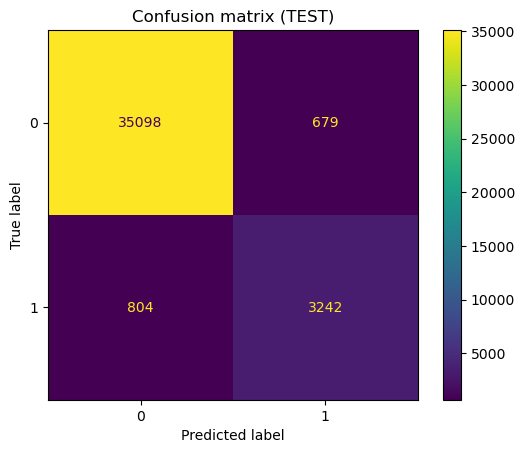

In [64]:
from sklearn.metrics import (precision_score, recall_score)

test_proba = final_model.predict_proba(X_test)[:, 1]

test_pred_th = (test_proba >= final_th).astype(int)

print("=== TEST metrics (threshold from VAL) ===")
print("threshold:", final_th)
print("F1:", round(f1_score(y_test, test_pred_th), 4))
print("Precision:", round(precision_score(y_test, test_pred_th), 4))
print("Recall:", round(recall_score(y_test, test_pred_th), 4))
print("Accuracy:", round(accuracy_score(y_test, test_pred_th), 4))
print("Balanced accuracy:", round(balanced_accuracy_score(y_test, test_pred_th), 4))

print("\n=== TEST ranking metrics (independent of threshold) ===")
print("ROC-AUC:", round(roc_auc_score(y_test, test_proba), 4))
print("PR-AUC (AP):", round(average_precision_score(y_test, test_proba), 4))

print("\n=== Classification report (thresholded) ===")
print(classification_report(y_test, test_pred_th, digits=4))

cm = confusion_matrix(y_test, test_pred_th)
print("Confusion matrix:\n", cm)

ConfusionMatrixDisplay(cm).plot(values_format="d")
plt.title("Confusion matrix (TEST)")
plt.show()

На тестовой выборке модель показывает F1 = 0.8139 при пороге 0.7.
Качество по классам сбалансированное: precision = 0.8268, recall = 0.8013, accuracy = 0.9628, balanced accuracy = 0.8912.

По “ранжирующим” метрикам качество тоже высокое: ROC-AUC = 0.9791, PR-AUC = 0.897.

Матрица ошибок показывает, что:

ложных срабатываний (FP) 679 (нетоксичные помечены как токсичные),

пропусков токсичности (FN) 804 (токсичные помечены как нетоксичные).
То есть модель чаще допускает пропуски токсичности (FN=804), чем ложные срабатывания на нетоксичных (FP=679).

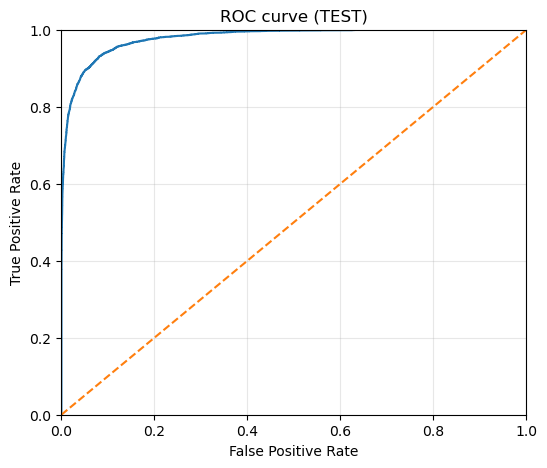

In [69]:
from sklearn.metrics import roc_curve

fpr, tpr, thr = roc_curve(y_test, test_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve (TEST)")
plt.grid(True, alpha=0.3)
plt.show()

ROC-кривая на тесте лежит близко к левому верхнему углу, что соответствует очень хорошей разделимости классов. Значение ROC-AUC ≈ 0.979 подтверждает, что модель уверенно ранжирует токсичные тексты выше нетоксичных почти при любых порогах.

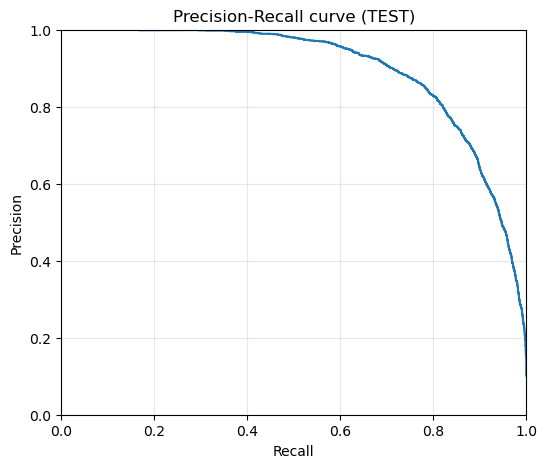

In [67]:
from sklearn.metrics import precision_recall_curve

prec, rec, thr = precision_recall_curve(y_test, test_proba)

plt.figure(figsize=(6, 5))
plt.plot(rec, prec)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve (TEST)")
plt.grid(True, alpha=0.3)
plt.show()


Precision–Recall кривая показывает стабильно высокую precision на широком диапазоне recall, но при стремлении к recall → 1 precision ожидаемо падает: чтобы “поймать почти всё токсичное”, приходится допускать больше ложных срабатываний..
С учётом дисбаланса классов PR-кривая здесь информативнее ROC: PR-AUC ≈ 0.897 означает, что модель хорошо удерживает качество именно на положительном (токсичном) классе.

Таким образом, итоговая модель (LogReg) показала на тесте высокие значения F1 (0.8139), ROC-AUC (0.9791) и PR-AUC (0.897), а также хороший баланс precision/recall. Ошибки распределены адекватно: модель слегка чаще пропускает токсичность, чем ошибочно помечает нетоксичное, что можно дополнительно корректировать порогом в зависимости от целей применения.

## Выводы

Итоги проекта по классификации токсичных комментариев:


1. Данные были подготовлены: выполнена очистка текста, лемматизация и формирование признаков (TF-IDF по словам и символам + простые статистические признаки).

2. Были обучены и сравнены несколько моделей (LogReg, LGBM, CatBoost, а также Dummy-бэйзлайн). По результатам на валидации логистическая регрессия показала лучшее сочетание качества и скорости обучения.

3. Финальная проверка на тестовой выборке подтвердила качество выбранного решения: метрики на тесте остались высокими, а анализ матрицы ошибок и кривых ROC/PR показал стабильную работу модели.


Полученная модель может использоваться как базовый фильтр токсичных сообщений (например, для предварительной модерации), а точность/полноту можно дополнительно настраивать выбором порога под конкретный сценарий.

В качестве возможного улучшения качества лемматизации можно использовать WordNetLemmatizer с учётом POS-тегов. В текущем решении основной вклад в качество даёт TF-IDF по словам и символам, поэтому POS-лемматизация оставлена как опциональная оптимизация.